<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gnb.configuration()

Library,Version
OS,nt [win32]
Python,"3.9.4 (tags/v3.9.4:1f2e308, Apr 4 2021, 13:27:16) [MSC v.1928 64 bit (AMD64)]"
IPython,7.22.0
MatPlotLib,3.4.1
Numpy,1.20.2
pyAgrum,0.20.1.9


# Credal Net from BN

In [3]:
bn=gum.fastBN("A->B[3]->C<-D<-A->E->F")
bn_min=gum.BayesNet(bn)
bn_max=gum.BayesNet(bn)
for n in bn.nodes():
  x=0.4*min(bn.cpt(n).min(),1-bn.cpt(n).max())
  bn_min.cpt(n).translate(-x)
  bn_max.cpt(n).translate(x)
    
cn=gum.CredalNet(bn_min,bn_max)
cn.intervalToCredal()

gnb.sideBySide(bn.cpt("B"),bn_min.cpt("B"),bn_max.cpt("B"))
cn

(gum::credal::CredalNet<double>@000001D69225D060) 
A[0,1]
<> : [[0.450067 , 0.549933] , [0.764314 , 0.235686]]

B[0,2]
<A:0> : [[0.189186 , 0.429808 , 0.381006] , [0.189186 , 0.43883 , 0.371984] , [0.198212 , 0.43883 , 0.362958] , [0.207234 , 0.429808 , 0.362958] , [0.198211 , 0.420784 , 0.381006] , [0.207234 , 0.420784 , 0.371983]]
<A:1> : [[0.408269 , 0.0225576 , 0.569174] , [0.408269 , 0.0315831 , 0.560148] , [0.41729 , 0.0315831 , 0.551127] , [0.426316 , 0.0225577 , 0.551127] , [0.417291 , 0.013535 , 0.569174] , [0.426316 , 0.013535 , 0.560149]]

C[0,1]
<B:0|D:0> : [[0.261218 , 0.738782] , [0.489834 , 0.510166]]
<B:1|D:0> : [[0.308659 , 0.691341] , [0.537275 , 0.462725]]
<B:2|D:0> : [[0.390828 , 0.609172] , [0.619444 , 0.380556]]
<B:0|D:1> : [[0.272634 , 0.727366] , [0.50125 , 0.49875]]
<B:1|D:1> : [[0.59992 , 0.40008] , [0.828537 , 0.171463]]
<B:2|D:1> : [[0.37378 , 0.62622] , [0.602395 , 0.397605]]

D[0,1]
<A:0> : [[0.370536 , 0.629464] , [0.453494 , 0.546506]]
<A:1> : [[0.0622172 , 0.937783] , [0.145176 , 0.854824]]

E[0,1]
<A:0> : [[0.562185 , 0.437815] , [0.634866 , 0.365134]]
<A:1> : [[0.0545094 , 0.945491] , [0.12719 , 0.87281]]

F[0,1]
<E:0> : [[0.129592 , 0.870408] , [0.302379 , 0.697621]]
<E:1> : [[0.687123 , 0.312877] , [0.859911 , 0.140089]]

#### We can use LBP on CN (L2U) only for binary credal networks (here B is not binary). We then propose the classical binarization (but warn the user that this leads to approximation in the inference)

In [4]:
cn2=gum.CredalNet(bn_min,bn_max)
cn2.intervalToCredal()
cn2.approximatedBinarization()
cn2.computeBinaryCPTMinMax()

gnb.sideBySide(cn,cn2)

Here, $B$ becomes 
- $B$-b$i$ : the $i$-th bit of B
- instrumental $B$-v$k$ : the indicator variable for each modality $k$ of $B$

In [5]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie2_lbp=gum.CNLoopyPropagation(cn2)
ie2_mc=gum.CNMonteCarloSampling(cn2)

In [7]:
gnb.sideBySide(gnb.getInference(cn,engine=ie_mc),gnb.getInference(cn2,engine=ie2_mc),gnb.getInference(cn2,engine=ie2_lbp))

In [8]:
gnb.sideBySide(ie_mc.CN(),ie_mc.marginalMin("F"),ie_mc.marginalMax("F"))
gnb.sideBySide(ie_mc.CN(),ie2_lbp.marginalMin("F"),ie2_lbp.marginalMax("F"))
print(cn)


A[0,1]
<> : [[0.450067 , 0.549933] , [0.764314 , 0.235686]]

B[0,2]
<A:0> : [[0.189186 , 0.429808 , 0.381006] , [0.189186 , 0.43883 , 0.371984] , [0.198212 , 0.43883 , 0.362958] , [0.207234 , 0.429808 , 0.362958] , [0.198211 , 0.420784 , 0.381006] , [0.207234 , 0.420784 , 0.371983]]
<A:1> : [[0.408269 , 0.0225576 , 0.569174] , [0.408269 , 0.0315831 , 0.560148] , [0.41729 , 0.0315831 , 0.551127] , [0.426316 , 0.0225577 , 0.551127] , [0.417291 , 0.013535 , 0.569174] , [0.426316 , 0.013535 , 0.560149]]

C[0,1]
<B:0|D:0> : [[0.261218 , 0.738782] , [0.489834 , 0.510166]]
<B:1|D:0> : [[0.308659 , 0.691341] , [0.537275 , 0.462725]]
<B:2|D:0> : [[0.390828 , 0.609172] , [0.619444 , 0.380556]]
<B:0|D:1> : [[0.272634 , 0.727366] , [0.50125 , 0.49875]]
<B:1|D:1> : [[0.59992 , 0.40008] , [0.828537 , 0.171463]]
<B:2|D:1> : [[0.37378 , 0.62622] , [0.602395 , 0.397605]]

D[0,1]
<A:0> : [[0.370536 , 0.629464] , [0.453494 , 0.546506]]
<A:1> : [[0.0622172 , 0.937783] , [0.145176 , 0.854824]]

E[0,1]
<A:

## Credal Net from bif files

In [9]:
cn=gum.CredalNet(os.path.join("res","cn/2Umin.bif"),os.path.join("res","cn/2Umax.bif"))
cn.intervalToCredal()

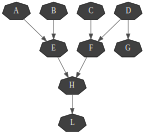

In [10]:
gnb.showCN(cn,"2")

In [11]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertEvidenceFile(os.path.join("res","cn/L2U.evi"))

In [12]:
ie.setRepetitiveInd(False)
ie.setMaxTime(1)
ie.setMaxIter(1000)

ie.makeInference()

In [13]:
gnb.sideBySide(cn,gnb.getInference(cn,targets={"A","H","L","D"},engine=ie,evs={"L":[0,1],"G":[1,0]}))

# Comparing inference in credal networks

In [14]:
import pyAgrum as gum

def showDiffInference(model,mc,lbp):
    for i in model.current_bn().nodes():
        a,b=mc.marginalMin(i)[:]
        c,d=mc.marginalMax(i)[:]
        
        e,f=lbp.marginalMin(i)[:]
        g,h=lbp.marginalMax(i)[:]
        
        plt.scatter([a,b,c,d],[e,f,g,h])
        

cn=gum.CredalNet("res/cn/2Umin.bif","res/cn/2Umax.bif")
cn.intervalToCredal()

#### The two inference give quite the same result

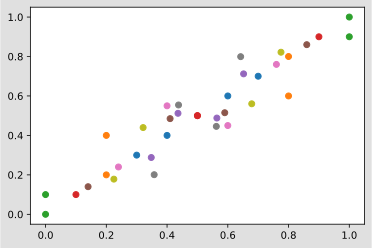

In [15]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.makeInference()

cn.computeBinaryCPTMinMax()
ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)

#### but not when evidence are inserted

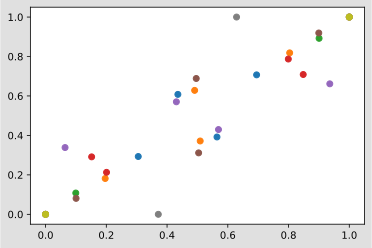

In [16]:
ie_mc=gum.CNMonteCarloSampling(cn)
ie_mc.insertEvidenceFile("res/cn/L2U.evi")
ie_mc.makeInference()

ie_lbp=gum.CNLoopyPropagation(cn)
ie_lbp.insertEvidenceFile("res/cn/L2U.evi")
ie_lbp.makeInference()

showDiffInference(cn,ie_mc,ie_lbp)


## Dynamical Credal Net

In [17]:
cn=gum.CredalNet(os.path.join("res","cn/bn_c_8.bif"),os.path.join("res","cn/den_c_8.bif"))
cn.bnToCredal(0.8,False)

In [18]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(True)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()

In [19]:
print(ie.dynamicExpMax("temp"))

(13.796595328550666, 11.478488709295707, 11.845172748957744, 11.764396335918441, 11.724899906122873, 11.725806107892172, 11.723056376790431, 11.723620567959546, 11.72346495036858)


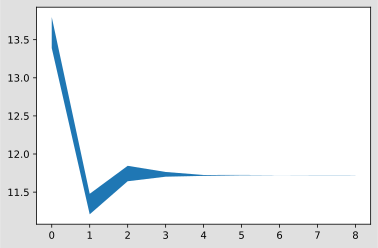

In [20]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

In [21]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(1000)

ie.makeInference()


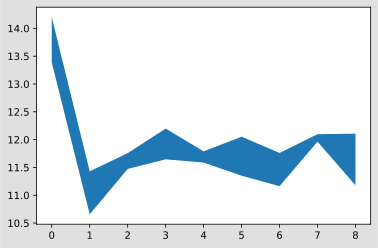

In [22]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"))

stopped with epsilon=0


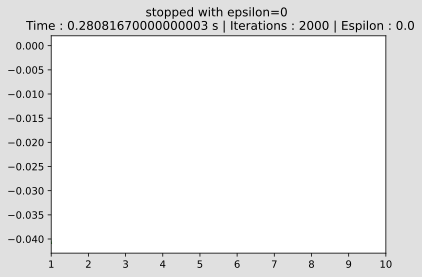

In [23]:
ie=gum.CNMonteCarloSampling(cn)
ie.insertModalsFile(os.path.join("res","cn/modalities.modal"))

ie.setRepetitiveInd(False)
ie.setMaxTime(30)
ie.setMaxIter(5000)

gnb.animApproximationScheme(ie)
ie.makeInference()
print(ie.messageApproximationScheme())

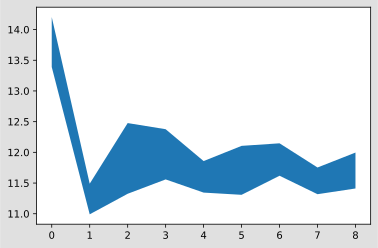

In [24]:
fig=figure()
ax=fig.add_subplot(111)
ax.fill_between(range(9),ie.dynamicExpMax("temp"),ie.dynamicExpMin("temp"));